# GridSearchCV for the Classifier

In this notebook, we perform a grid search on two types of classifiers: (a) logistic regression and (b) SVM.

The features are extracted using a vectorizer with the following params:

```python
dict(
    analyzer='char', 
    sg_only=False, 
    sanitizer=np_sanitize, # <- the only difference from 07-GridSearchClassifier_NoSanitization 
    max_features=10000, 
    ngram_range=(3, 3),
    sublinear_tf=True, 
    use_idf=True
)
```

__Note__: here, the data _are sanitized_.

In [18]:
%run notebook_utils.py
%run gridsearch_utils.py

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
import matplotlib

# set big font in plots
SMALL_SIZE = 20
matplotlib.rc('font', size=SMALL_SIZE)
matplotlib.rc('axes', titlesize=SMALL_SIZE)

In [4]:
%cd ..
from langid import sanitize, np_sanitize, WrappedVectorizer
%cd -

/Users/Lin/git/SwigSpot/language-detection
/Users/Lin/git/SwigSpot/language-detection/notebooks


# data loading

In [19]:
X, y = load_data()

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=0)
sms_any_X, sms_any_y = load_sms_any()
X_valid, y_valid = load_validation_data()

# Creating the vectorizer

In [26]:
vect_options = dict(analyzer='char', sg_only=False, sanitizer=np_sanitize, max_features=10000, ngram_range=(3, 3),
    sublinear_tf=True, use_idf=True)
vect = WrappedVectorizer(**vect_options)
Xvec = vect.fit_transform(X, y)

# GridSearch on LogisticRegression

In [7]:
params = dict(C=[1, 10, 20, 100], solver=('newton-cg', 'liblinear'))

clf = LogisticRegression()
gs = GridSearchCV(clf, params, n_jobs=-1, verbose=1)

gs.fit(Xvec, y)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   29.1s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [1, 10, 20, 100], 'solver': ('newton-cg', 'liblinear')},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [8]:
print_best_estimator(gs)
print_scores(gs)


Best score: 0.990
Best parameters set:
	C: 20
	solver: 'liblinear'
Grid scores on development set:

0.988 (+/-0.004): :1, :newton-cg
0.988 (+/-0.004): :1, :liblinear
0.990 (+/-0.005): :10, :newton-cg
0.990 (+/-0.005): :10, :liblinear
0.990 (+/-0.004): :20, :newton-cg
0.990 (+/-0.004): :20, :liblinear
0.989 (+/-0.005): :100, :newton-cg
0.989 (+/-0.005): :100, :liblinear


## testing multi_class parameter (only for newton-cg)

In [9]:
params2 = dict(C=[1, 10, 20, 100], multi_class=('ovr', 'multinomial'))

clf2 = LogisticRegression(solver='newton-cg')
gs2 = GridSearchCV(clf2, params2, n_jobs=-1, verbose=1)

gs2.fit(Xvec, y)

print_best_estimator(gs2)
print_scores(gs2)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   29.7s finished



Best score: 0.990
Best parameters set:
	C: 20
	multi_class: 'ovr'
Grid scores on development set:

0.988 (+/-0.004): :1, class:ovr
0.989 (+/-0.003): :1, class:multinomia
0.990 (+/-0.005): :10, class:ovr
0.989 (+/-0.004): :10, class:multinomia
0.990 (+/-0.004): :20, class:ovr
0.989 (+/-0.004): :20, class:multinomia
0.989 (+/-0.005): :100, class:ovr
0.989 (+/-0.005): :100, class:multinomia


# tuning C only (liblinear)

In [10]:
%%time

lrcv = LogisticRegressionCV(Cs=50) # If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4.   
lrcv.fit(Xvec, y)

for (c, s) in lrcv.scores_.items():
    print(c, s.mean(axis=0).max(), s.mean(axis=0).argmax())

0 0.9931237346984281 36
1 0.9983215351244913 42
2 0.9964536939531916 43
3 0.9983757795853516 38
4 0.9844874267010648 33
CPU times: user 11min 2s, sys: 18.7 s, total: 11min 21s
Wall time: 2min 52s


# Get real results

TEST SET
             precision    recall  f1-score   support

         de     0.9932    0.9918    0.9925      1462
         fr     0.9986    0.9980    0.9983      1468
         en     0.9961    0.9954    0.9958      1538
         it     0.9986    0.9973    0.9980      1482
         sg     0.9889    0.9930    0.9910      1438

avg / total     0.9951    0.9951    0.9951      7388



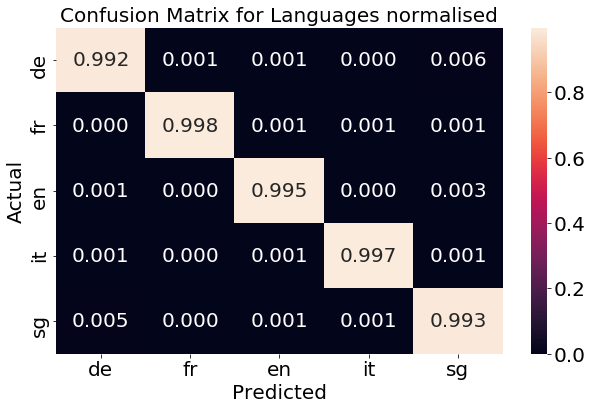

SMS RECALL
total samples    10692
total errors        74 (0.69%)
---------------------------------
languages detected
    de       61
    fr        8
    en        2
    it        3
    sg    10618


VALIDATION SET
             precision    recall  f1-score   support

         de     0.9452    0.9904    0.9673      2613
         fr     0.9977    0.9981    0.9979      2613
         en     0.9981    0.9950    0.9966      2613
         it     0.9977    0.9985    0.9981      2613
         sg     0.9848    0.9395    0.9616      2613

avg / total     0.9847    0.9843    0.9843     13065



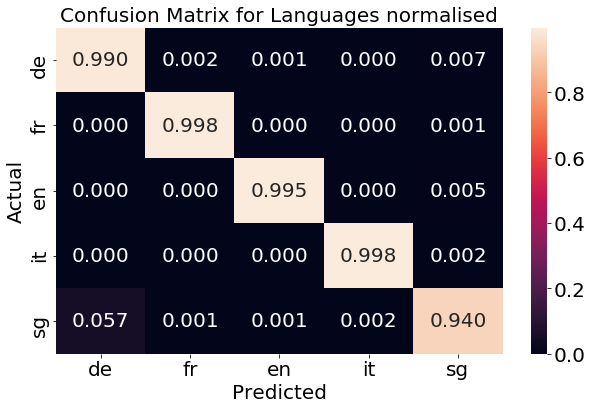

In [20]:
pipe1 = Pipeline([
    ('vect', WrappedVectorizer(**vect_options)),
    ('clf', LogisticRegression(C=75))
])

pipe1.fit(X_train, y_train)

print("TEST SET")
print("========")
y_pred = pipe1.predict(X_test)
print_results(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, normalised=True)

print("SMS RECALL")
print("==========")

test_recall_with_sms(pipe1)

print("\n\nVALIDATION SET")
print("===============")
y_valid_pred = pipe1.predict(X_valid)
print_results(y_valid, y_valid_pred)
plot_confusion_matrix(y_valid, y_valid_pred, normalised=True)

Testing on SMS any

             precision    recall  f1-score   support

         de     0.9935    0.7562    0.8588       201
         fr     1.0000    0.9254    0.9612       201
         en     0.9927    0.6766    0.8047       201
         it     1.0000    0.9602    0.9797       201
         sg     0.5952    0.9950    0.7449       201

avg / total     0.9163    0.8627    0.8699      1005



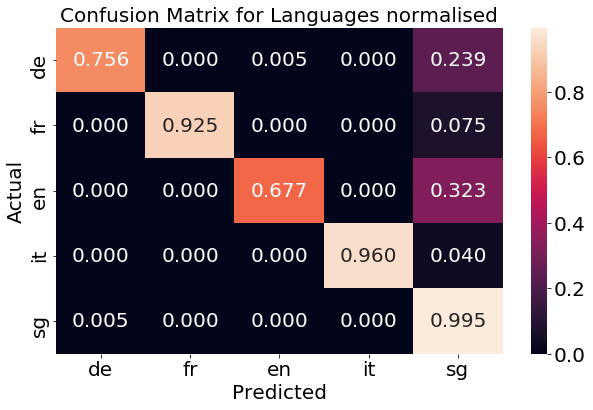

In [21]:
print("Testing on SMS any")
print("==================\n")
sms_any_predicted = pipe1.predict(sms_any_X)
print_results(sms_any_y, sms_any_predicted)
plot_confusion_matrix(sms_any_y, sms_any_predicted, normalised=True)

# SVM

In [12]:
import warnings
warnings.filterwarnings('ignore', 'Solver terminated early.*')

In [13]:
from sklearn.svm import SVC


# Set the parameters by cross-validation
svc_params = [
    {'kernel': ['rbf'], 
     'gamma': [1e-3, 1e-4],
     'C': [1, 10, 100, 1000]
    },
    {'kernel': ['linear'], 
     'C': [1, 10, 100, 1000]
    }
]

gsvm = GridSearchCV(SVC(C=1, max_iter=1000), svc_params, n_jobs=-1, verbose=1)

gsvm.fit(Xvec, y)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed: 58.8min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=1000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}, {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=1)

In [14]:
print_best_estimator(gsvm)


Best score: 0.989
Best parameters set:
	C: 1
	kernel: 'linear'


In [15]:
print_scores(gsvm)

Grid scores on development set:

0.943 (+/-0.018): :1, :0.001, :rbf
0.935 (+/-0.018): :1, :0.0001, :rbf
0.982 (+/-0.002): :10, :0.001, :rbf
0.946 (+/-0.010): :10, :0.0001, :rbf
0.989 (+/-0.003): :100, :0.001, :rbf
0.982 (+/-0.001): :100, :0.0001, :rbf
0.988 (+/-0.005): :1000, :0.001, :rbf
0.989 (+/-0.003): :1000, :0.0001, :rbf
0.989 (+/-0.005): :1, :linear
0.988 (+/-0.007): :10, :linear
0.988 (+/-0.007): :100, :linear
0.988 (+/-0.007): :1000, :linear


TEST SET
             precision    recall  f1-score   support

         de     0.9959    0.9884    0.9921      1462
         fr     0.9986    0.9966    0.9976      1468
         en     0.9980    0.9928    0.9954      1538
         it     0.9980    0.9953    0.9966      1482
         sg     0.9781    0.9958    0.9869      1438

avg / total     0.9938    0.9938    0.9938      7388



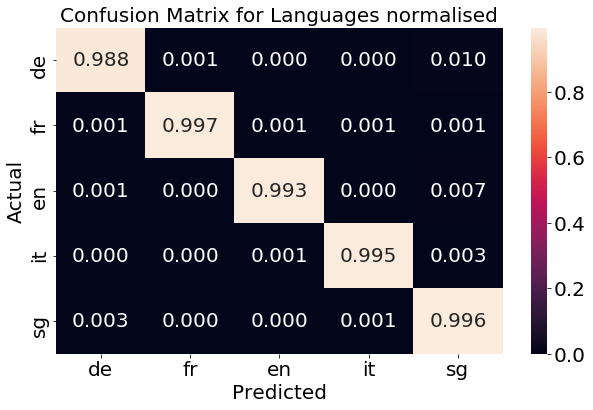

SMS RECALL
total samples    10692
total errors        42 (0.39%)
---------------------------------
languages detected
    de       39
    fr        1
    en        1
    it        1
    sg    10650


VALIDATION SET
             precision    recall  f1-score   support

         de     0.9497    0.9824    0.9658      2613
         fr     0.9981    0.9966    0.9973      2613
         en     0.9973    0.9931    0.9952      2613
         it     0.9981    0.9958    0.9969      2613
         sg     0.9713    0.9457    0.9583      2613

avg / total     0.9829    0.9827    0.9827     13065



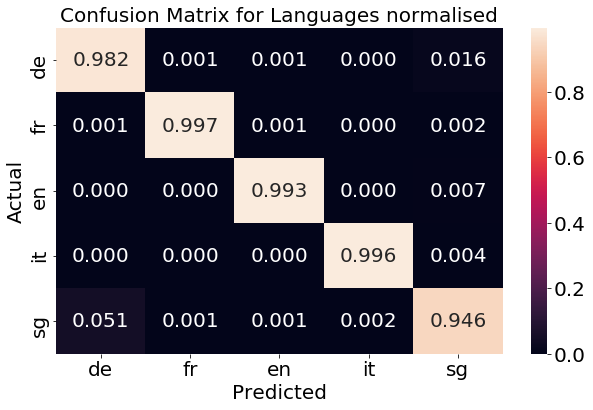

CPU times: user 13min 1s, sys: 4.02 s, total: 13min 5s
Wall time: 1h 22min 27s


In [27]:
%%time
svm_pipe = Pipeline([
    ('vect', WrappedVectorizer(**vect_options)),
    ('clf', SVC(max_iter=1000, probability=True, C=100, gamma=0.001, kernel='rbf'))
])


svm_pipe.fit(X_train, y_train)

print("TEST SET")
print("========")
y_pred = svm_pipe.predict(X_test)
print_results(y_test, y_pred)
plot_confusion_matrix(y_test, y_pred, normalised=True)

print("SMS RECALL")
print("==========")

test_recall_with_sms(svm_pipe)

print("\n\nVALIDATION SET")
print("===============")
y_valid_pred = svm_pipe.predict(X_valid)
print_results(y_valid, y_valid_pred)
plot_confusion_matrix(y_valid, y_valid_pred, normalised=True)

Testing on SMS any

             precision    recall  f1-score   support

         de     1.0000    0.7214    0.8382       201
         fr     1.0000    0.9254    0.9612       201
         en     1.0000    0.7015    0.8246       201
         it     1.0000    0.9552    0.9771       201
         sg     0.5894    1.0000    0.7417       201

avg / total     0.9179    0.8607    0.8685      1005



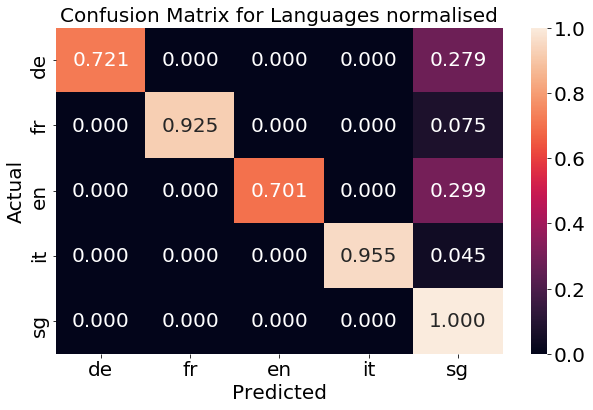

In [28]:
print("Testing on SMS any")
print("==================\n")

sms_any_predicted = svm_pipe.predict(sms_any_X)
print_results(sms_any_y, sms_any_predicted)
plot_confusion_matrix(sms_any_y, sms_any_predicted, normalised=True)